# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9966637387078838


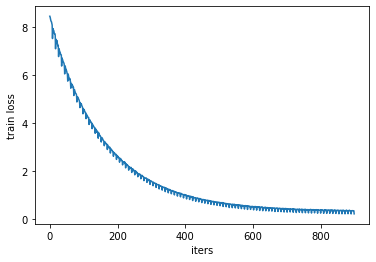

In [3]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
            
                sigmoid = self.predict_proba(batch_X)
                
                # forward pass
                # <TODO> [1 point] calculate batch loss
                loss = -1/self.batch_size * np.sum(batch_y * np.log(sigmoid) + (1 - batch_y) * np.log(1 - sigmoid))
                loss += self.llambda/2 * np.dot(self.w.T, self.w)

                # backward pass
                # <TODO> [2 points] calculate batch gradients
                grad_w = -1/self.batch_size * batch_X.T * (batch_y - sigmoid) + self.llambda * self.w
                grad_b = -1/self.batch_size * np.sum(batch_y - sigmoid)

                # SGD optimization step
                # <TODO> [1 point]
                self.w = self.w - self.lr * grad_w
                self.b = self.b - self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X * self.w + self.b
        p = 1/(1 + np.exp(-z))
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = torch.mm(x, self.W) + self.b
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    consecutive_growth_epochs = 0
    last_low = np.inf
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        
        if epoch_valid_loss > last_low:
            consecutive_growth_epochs += 1
        else:
            consecutive_growth_epochs = 0
            last_low = epoch_valid_loss
        if consecutive_growth_epochs == early_stopping_patience:
            print(f'stopped early due to increasing validation loss for last {consecutive_growth_epochs} epochs')
            break

    return history 

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = np.argmax(F.softmax(model(batch_x), dim=1), axis=1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [9]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



train loss: 3.238 valid loss:3.007



train loss: 2.803 valid loss:2.651



train loss: 2.458 valid loss:2.356



train loss: 2.176 valid loss:2.127



train loss: 1.950 valid loss:1.961



train loss: 1.767 valid loss:1.834



train loss: 1.617 valid loss:1.707



train loss: 1.490 valid loss:1.581



train loss: 1.388 valid loss:1.504



train loss: 1.303 valid loss:1.445



train loss: 1.229 valid loss:1.373



train loss: 1.170 valid loss:1.324



train loss: 1.115 valid loss:1.285



train loss: 1.067 valid loss:1.240



train loss: 1.027 valid loss:1.212



train loss: 0.994 valid loss:1.183



train loss: 0.963 valid loss:1.157



train loss: 0.934 valid loss:1.139



train loss: 0.910 valid loss:1.113



train loss: 0.887 valid loss:1.100



train loss: 0.871 valid loss:1.080



train loss: 0.855 valid loss:1.069



train loss: 0.838 valid loss:1.053



train loss: 0.824 valid loss:1.047



train loss: 0.813 valid loss:1.035



train loss: 0.798 valid loss:1.029



train loss: 0.792 valid loss:1.017



train loss: 0.782 valid loss:1.015



train loss: 0.771 valid loss:1.003



train loss: 0.764 valid loss:1.001



train loss: 0.758 valid loss:1.000



train loss: 0.754 valid loss:0.992



train loss: 0.746 valid loss:0.992



train loss: 0.741 valid loss:0.982



train loss: 0.736 valid loss:0.976



train loss: 0.733 valid loss:0.977



train loss: 0.728 valid loss:0.973



train loss: 0.728 valid loss:0.974



train loss: 0.722 valid loss:0.972



train loss: 0.718 valid loss:0.966



train loss: 0.714 valid loss:0.965



train loss: 0.712 valid loss:0.962



train loss: 0.709 valid loss:0.963



train loss: 0.706 valid loss:0.959



train loss: 0.705 valid loss:0.962



train loss: 0.700 valid loss:0.957



train loss: 0.701 valid loss:0.953



train loss: 0.699 valid loss:0.959



train loss: 0.695 valid loss:0.956
stopped early due to increasing validation loss for last 2 epochs


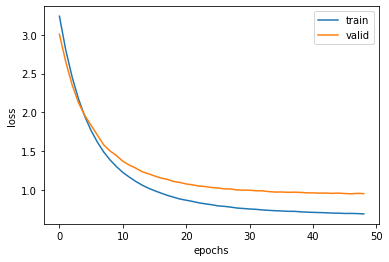

In [10]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [11]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.7984599044078597

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

$p(y_i=k|x_i)$ - predicted probability of object $x_i$ belonging to class $k$.
In case of uniformly random guessing classifier $p(y_i=k) = 0.05$, for every class.

By definition, cross-entropy loss equals to $$-\sum_{i=1}^{N} \sum_{k=0}^{19} [y_i = k] * log(p(y_i=k|x_i))$$
After substuting the probablity we get:
$$-\sum_{i=1}^{N} \sum_{k=0}^{19} [y_i = k] * log(0.05) = -log(0.05) * \sum_{i=1}^{N} \sum_{k=0}^{19} [y_i = k] = -log(0.05) * 1 \approx 2.995732273553991 $$

Cross-entropy loss is equal to $-log(0.05)$ ~= 2.995732273553991

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

$$Acc = \frac{1}{N} \sum_{i=1}^{N}{[y_i = k]}$$
The accuracy of constant prediction classifier is equal to the ratio of objects belonging to class K to total size of dataset, K being the predicted class.
Given that there are 20 classes, the mean accuracy of all constant prediction classifiers will be 1/20 = 0.05.